<a href="https://colab.research.google.com/github/tintenderete/TFM-Algoritmo-con-redes-evolutivas/blob/main/test_evolutivo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PLANTEAMIENTO INICIAL

Planteamiento inicial, algunas cosas cambiaran durante el desarrollo.

Esta es una primera iteracion de un modelo evolutivo, se intentara simplificar lo maximo posible para ganar velocidad.

## PUNTO 0 : MODELOS

Los modelos invertiran durante 1 año, cada 30 timesteps.

EL modelo evolutivo se comparara con un modelo no evolutivo.  El no evolutivo , en este test, no es realmente un modelo pero lo ignoraremos.

El modelo no evolutivo sera una frontera de marko que invertira en los X activos con mejor ratio de sharpe. 

El modelo evolutivo hara lo similar con la excepcion de que seleccionara los X mejores, en funcion de su output.

## PUNTO 1 : DATOS 

Usaremos los precios de cierre diarios del IBEX 35 descargados con la api yahoo finance. 

Si algun activo da problemas sera eliminado, y los nans seran rellenas con fills. Se instentara usar un periodo historico que de pocos problemas.

Usaremos 3 años para train y 1 año para test.
Los datos se generaran en periodos pseudo-mensuales, es decir, empezando en el primer dia cada 30 dias.

Cada ejemplo de entrenamiento constara de 60 periodos diarios  , tendra 3 canales (para cada activo) : 
            
            - retornos logaritmicos diarios

            - media movil (de retornos logaritmicos) de los ultimos 60 dias

            - desviacion tipica movil (de retornos logaritmicos) de los ultimos 60 dias


x.shape => (BATCH, 60, 35,  3)

## PUNTO 2 : FUNCION LISTAS

Para rankear los activos usaremos el ratio de sharpe.

y.shape => (BATCH, 35, )

## PUNTO 3 : INICIALIZACION DE INDIVIDUOS

Se utilizara el metodo desarrollado en el notebook A_individuos_3

Se usaran pocos individuos, la intencion es utilizar alrededor de 100.

##PUNTO 4 : EVALUACION / FITNESS

In [45]:
"""

Se entrenara en batches de 1 dato

Se evaluara despues de entrenar con todos los datos.

La funcion de coste utilizada sera : 

def perdida_listas(ranking_real, ranking_predicho):
    diferencias = tf.abs(ranking_real - ranking_predicho)
    diferencias_ponderadas = diferencias / (ranking_predicho + 1e-7) 
    perdida_total = tf.reduce_sum(diferencias_ponderadas)
    return perdida_total

esta funcion castiga mas cuando los peores activos son clasificados como mejores.

La razon inicial para empezar por esta funcion es que , dado que nuestro 
objetivo es calcular una frontera de marko en los X mejores, 
realmente no necesitamos que esten fielmente ordenados, lo que queremos es 
asegurarnos de que los activos interesantes sean clasificados entre los X mejores.
     

"""

'\n\nSe entrenara en batches de 1 dato\n\nSe evaluara despues de entrenar con todos los datos.\n\nLa funcion de coste utilizada sera : \n\ndef perdida_listas(ranking_real, ranking_predicho):\n    diferencias = tf.abs(ranking_real - ranking_predicho)\n    diferencias_ponderadas = diferencias / (ranking_predicho + 1e-7) \n    perdida_total = tf.reduce_sum(diferencias_ponderadas)\n    return perdida_total\n\nesta funcion castiga mas cuando los peores activos son clasificados como mejores.\n\nLa razon inicial para empezar por esta funcion es que , dado que nuestro \nobjetivo es calcular una frontera de marko en los X mejores, \nrealmente no necesitamos que esten fielmente ordenados, lo que queremos es \nasegurarnos de que los activos interesantes sean clasificados entre los X mejores.\n     \n\n'

##PUNTO 5 : SELECCION 

In [46]:
"""

Seleccionaremos los X mejores en funcion de la funcion de coste.

¿ Emparejamiento ? 

Teniendo un pull de X individuos, se elegiran al azar, sin reemplazo y de 2 en 2,  de dentro del pull, 

"""

'\n\nSeleccionaremos los X mejores en funcion de la funcion de coste.\n\n¿ Emparejamiento ? \n\nTeniendo un pull de X individuos, se elegiran al azar, sin reemplazo y de 2 en 2,  de dentro del pull, \n\n'

## PUNTO 6 : CRUCE

In [47]:
"""

Utilizaremos un cruce uniforme para favorecer la biodiversidad. 

"""

'\n\nUtilizaremos un cruce uniforme para favorecer la biodiversidad. \n\n'

## PUNTO 7 : MUTACION

In [48]:
"""

aleatoriamente se reiniciaran todos los genes de layers o activaciones o etc...

"""

'\n\naleatoriamente se reiniciaran todos los genes de layers o activaciones o etc...\n\n'

## PUNTO 8 : REEMPLAZO

In [49]:
"""

Pasaran a la siguiente generacion:  

  Los X mejores .

  Los hijos de los X mejores. ( 2 hijos por pareja)

  X nuevos individuos random ( Inmigracion )


"""

'\n\nPasaran a la siguiente generacion:  \n\n  Los X mejores .\n\n  Los hijos de los X mejores. ( 2 hijos por pareja)\n\n  X nuevos individuos random ( Inmigracion )\n\n\n'

# DATOS

In [50]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

## DESCARGA

In [51]:
symbols = [
"ANA.MC", "ACX.MC", "ACS.MC", "AENA.MC", "AMS.MC", "MTS.MC", "SAB.MC", "BKIA.MC", "BKT.MC", "BBVA.MC", "CABK.MC",
"CLNX.MC", "CIE.MC", "ENG.MC", "ELE.MC", "FER.MC", "GRF.MC", "IAG.MC", "IBE.MC", "ITX.MC", "IDR.MC", "COL.MC",
"MEL.MC", "MRL.MC", "NTGY.MC", "PHM.MC", "REE.MC", "REP.MC", "SGRE.MC", "SLR.MC", "TRE.MC", "TEF.MC", "VIS.MC",
"VWS.CO"
]

In [52]:
# Descargar datos
start_date = "2019-01-01"
end_date = "2023-01-01"
data = yf.download(symbols, start=start_date, end=end_date)

[*********************100%***********************]  34 of 34 completed

3 Failed downloads:
- SGRE.MC: No timezone found, symbol may be delisted
- REE.MC: No timezone found, symbol may be delisted
- BKIA.MC: No timezone found, symbol may be delisted


In [53]:
prices = data["Close"]

## LIMPIEZA

In [54]:
prices.isna().sum()

ACS.MC        2
ACX.MC        2
AENA.MC       2
AMS.MC        2
ANA.MC        2
BBVA.MC       2
BKIA.MC    1028
BKT.MC        2
CABK.MC       2
CIE.MC        2
CLNX.MC       2
COL.MC        2
ELE.MC        2
ENG.MC        2
FER.MC        2
GRF.MC        2
IAG.MC        2
IBE.MC        2
IDR.MC        2
ITX.MC        2
MEL.MC        2
MRL.MC        2
MTS.MC        2
NTGY.MC       2
PHM.MC        2
REE.MC     1028
REP.MC        2
SAB.MC        2
SGRE.MC    1028
SLR.MC        2
TEF.MC        2
TRE.MC        2
VIS.MC        2
VWS.CO       27
dtype: int64

In [55]:
# Preprocesar datos
prices = prices.fillna(method="ffill")

In [56]:
prices.isna().sum()

ACS.MC        0
ACX.MC        0
AENA.MC       0
AMS.MC        0
ANA.MC        0
BBVA.MC       0
BKIA.MC    1028
BKT.MC        0
CABK.MC       0
CIE.MC        0
CLNX.MC       0
COL.MC        0
ELE.MC        0
ENG.MC        0
FER.MC        0
GRF.MC        0
IAG.MC        0
IBE.MC        0
IDR.MC        0
ITX.MC        0
MEL.MC        0
MRL.MC        0
MTS.MC        0
NTGY.MC       0
PHM.MC        0
REE.MC     1028
REP.MC        0
SAB.MC        0
SGRE.MC    1028
SLR.MC        0
TEF.MC        0
TRE.MC        0
VIS.MC        0
VWS.CO        0
dtype: int64

In [57]:
prices = prices.drop(["BKIA.MC", "REE.MC", "SGRE.MC"  ], axis = 1)

In [58]:
prices.isna().sum().sum() == 0

True

(1028, 31)


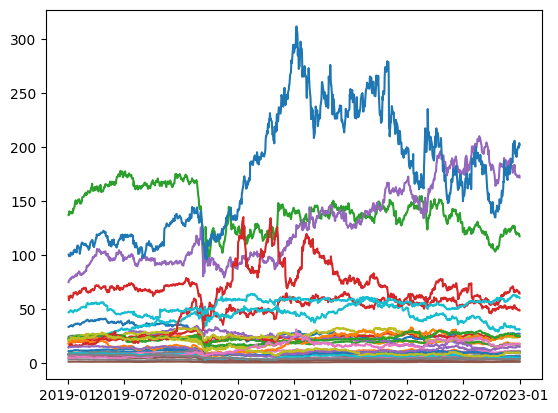

In [59]:
print(prices.shape)
plt.plot(prices);

In [60]:
returns = np.log(prices / prices.shift(1)).dropna()

(1027, 31)


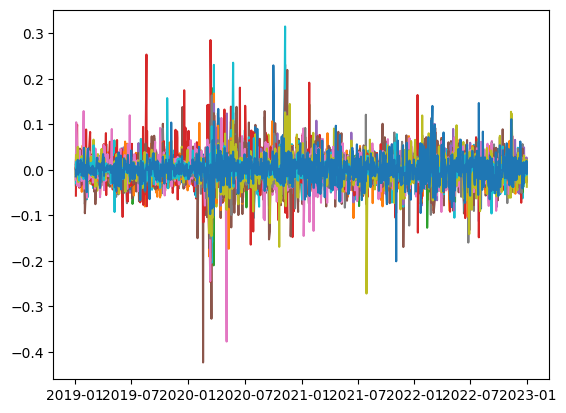

In [61]:
print(returns.shape)
plt.plot(returns);

In [62]:
rolling_mean = returns.rolling(60).mean()

In [63]:
rolling_mean[0:60].tail()

,ACS.MC,ACX.MC,AENA.MC,AMS.MC,ANA.MC,BBVA.MC,BKT.MC,CABK.MC,CIE.MC,CLNX.MC,...,MTS.MC,NTGY.MC,PHM.MC,REP.MC,SAB.MC,SLR.MC,TEF.MC,TRE.MC,VIS.MC,VWS.CO
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-27 00:00:00,0.002876,0.000239,0.002881,0.001852,0.004695,0.001543,-0.000318,-0.001881,0.001438,0.002656,...,0.000281,0.001767,0.00345,0.001164,-0.002053,0.001834,0.000409,0.002951,0.002606,0.001553


In [64]:
rolling_mean = rolling_mean[59:]

In [65]:
rolling_mean[0:1]

,ACS.MC,ACX.MC,AENA.MC,AMS.MC,ANA.MC,BBVA.MC,BKT.MC,CABK.MC,CIE.MC,CLNX.MC,...,MTS.MC,NTGY.MC,PHM.MC,REP.MC,SAB.MC,SLR.MC,TEF.MC,TRE.MC,VIS.MC,VWS.CO
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-27 00:00:00,0.002876,0.000239,0.002881,0.001852,0.004695,0.001543,-0.000318,-0.001881,0.001438,0.002656,...,0.000281,0.001767,0.00345,0.001164,-0.002053,0.001834,0.000409,0.002951,0.002606,0.001553


(968, 31)


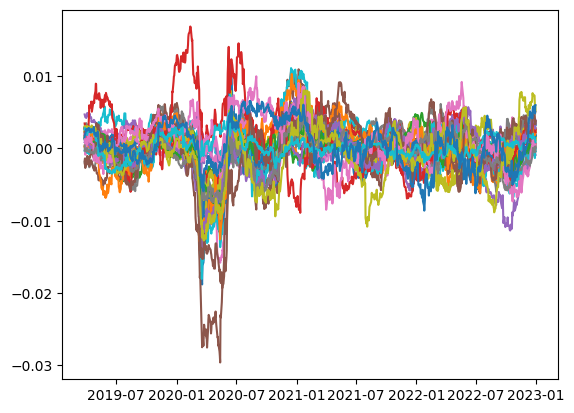

In [66]:
print(rolling_mean.shape)
plt.plot(rolling_mean);

In [67]:
rolling_std = returns.rolling(60).std()

In [68]:
rolling_std[0:60].tail()

,ACS.MC,ACX.MC,AENA.MC,AMS.MC,ANA.MC,BBVA.MC,BKT.MC,CABK.MC,CIE.MC,CLNX.MC,...,MTS.MC,NTGY.MC,PHM.MC,REP.MC,SAB.MC,SLR.MC,TEF.MC,TRE.MC,VIS.MC,VWS.CO
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-27 00:00:00,0.010227,0.016879,0.01033,0.016393,0.010119,0.014891,0.015218,0.019549,0.020243,0.015502,...,0.023837,0.008252,0.032059,0.009695,0.026972,0.033458,0.010486,0.020812,0.012204,0.016094


In [69]:
rolling_std = rolling_std[59:]

In [70]:
rolling_std[0:1]

,ACS.MC,ACX.MC,AENA.MC,AMS.MC,ANA.MC,BBVA.MC,BKT.MC,CABK.MC,CIE.MC,CLNX.MC,...,MTS.MC,NTGY.MC,PHM.MC,REP.MC,SAB.MC,SLR.MC,TEF.MC,TRE.MC,VIS.MC,VWS.CO
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-27 00:00:00,0.010227,0.016879,0.01033,0.016393,0.010119,0.014891,0.015218,0.019549,0.020243,0.015502,...,0.023837,0.008252,0.032059,0.009695,0.026972,0.033458,0.010486,0.020812,0.012204,0.016094


(968, 31)


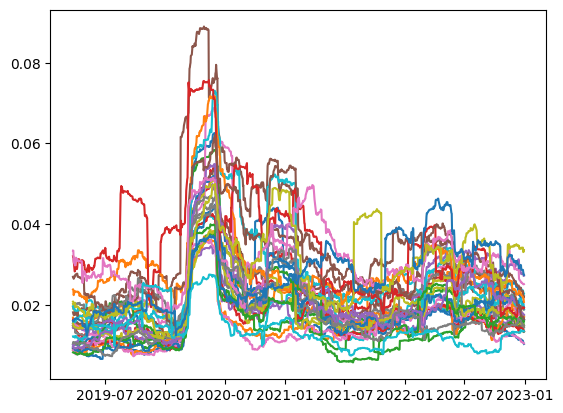

In [71]:
print(rolling_std.shape)
plt.plot(rolling_std);

In [72]:
returns = returns[59:]

## Datos

In [73]:
print("returns.shape " + str(returns.shape))
print("rolling_mean.shape " + str(rolling_mean.shape))
print("rolling_std.shape " + str(rolling_std.shape))

returns.shape (968, 31)
rolling_mean.shape (968, 31)
rolling_std.shape (968, 31)


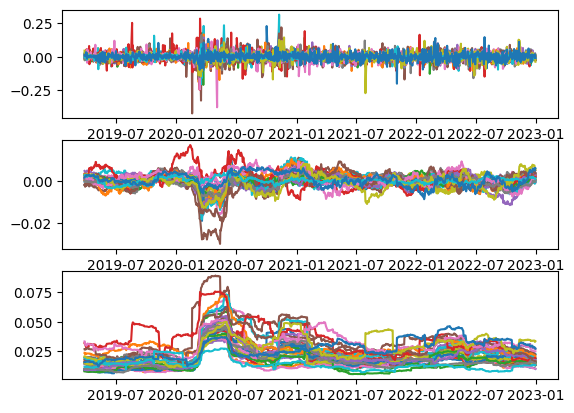

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(returns);

ax2.plot(rolling_mean);

ax3.plot(rolling_std);


## Datos Preparados

In [75]:
returns.shape, rolling_mean.shape, rolling_std.shape 

((968, 31), (968, 31), (968, 31))

In [76]:
returns = returns[:-8]
rolling_mean = rolling_mean[:-8]
rolling_std = rolling_std[:-8]

In [77]:
returns.shape, rolling_mean.shape, rolling_std.shape 

((960, 31), (960, 31), (960, 31))

In [78]:
datos = np.zeros((returns.shape[0], returns.shape[1], 3))
datos[:,:,0] = returns
datos[:,:,1] = rolling_mean
datos[:,:,2] = rolling_std
datos.shape

(960, 31, 3)

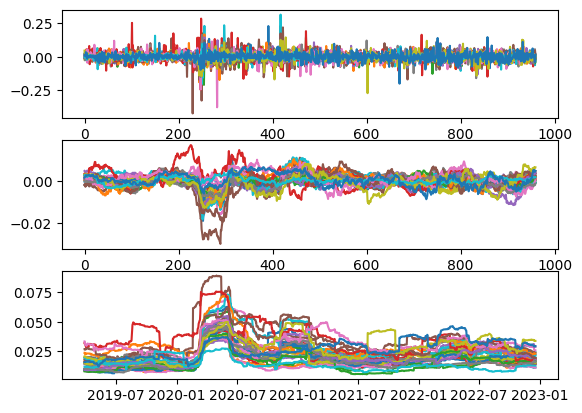

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(datos[:,:,0]);

ax2.plot(datos[:,:,1]);

ax3.plot(rolling_std);

## DATOS BATCHEADOS -> datos_batches

In [80]:
datos_batches = datos.reshape((-1, 60 ,datos.shape[1],  datos.shape[2]))
datos_batches.shape

(16, 60, 31, 3)

# FUNCION LISTAS

In [81]:
def ratio_sharpe(returns):

  risk_free_rate = 0.01  
  mean_returns = np.mean(returns, axis=0) * 252
  std_returns = np.std(returns, axis=0) * np.sqrt(252)
  sharpe_ratios = (mean_returns - risk_free_rate) / std_returns

  return sharpe_ratios

def lista(returns):
  return np.argsort(returns)[::-1]

## LISTAS -> listas

In [82]:
ratios_sharpe = []
listas = []

for batch in range(datos_batches.shape[0]):
  
  new_ratios = ratio_sharpe(datos_batches[batch,:,:,0])
  ratios_sharpe.append(new_ratios)

  new_lista = lista(new_ratios)
  listas.append(new_lista)

ratios_sharpe = np.array(ratios_sharpe)
listas = np.array(listas)

In [83]:
listas.shape, datos_batches.shape

((16, 31), (16, 60, 31, 3))

# X e Y

In [84]:
"""

movemos en 1 las listas para que la Y sean el ranking de 60 periodos despues

"""

'\n\nmovemos en 1 las listas para que la Y sean el ranking de 60 periodos despues\n\n'

In [85]:
Y = np.roll( listas , shift = -1, axis = 0)[:-1]

In [86]:
X = datos_batches[:-1]

In [87]:
X.shape, Y.shape

((15, 60, 31, 3), (15, 31))

# INICIALIZACION DE INDIVIDUOS

In [267]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import ConvLSTM1D, Dense, Conv2D, LSTM, GRU, Reshape, ConvLSTM2D, Conv3D, TimeDistributed, Flatten
import keras
import tensorflow as tf

## Vars

In [268]:
layers = []
dims = []
activations = []

individuos = []
models = []

# GEN mas largo => tipo_layer,  activation=info[0],   filters=info[1],      kernel_size=info[2]
len_gen = 4
num_genes = 4 
size_cadena = len_gen * num_genes
num_individuos = 20

layers_random = []
activations_random = [] 
units_random = []
kernels_size_random = []

rango_minimo_units = 1
rango_maximo_units = 100

rango_minimo_kernel_size = 1
rango_maximo_kernel_size = 4

## layers

In [269]:
layers.append( lambda info : Dense(                     activation=activations[info[0]],   units=info[1] ) )
dims.append(-1)

"""
layers.append( lambda info : TimeDistributed(Dense(     activation=activations[info[0]],   units=info[1] ) ) )
dims.append(4)

layers.append( lambda info : ConvLSTM2D(                activation=activations[info[0]],   filters=info[1],      kernel_size=(info[2],info[2]),                 padding='same'))
dims.append(5)

layers.append( lambda info : ConvLSTM1D(                activation=activations[info[0]],   filters=info[1],      kernel_size=(info[2],),                        padding='same'))
dims.append(4)

layers.append( lambda info : Conv3D(                    activation=activations[info[0]],   filters=info[1],      kernel_size=(info[2],info[2],info[2] ),        padding='same'))
dims.append(5)

layers.append( lambda info : Conv2D(                    activation=activations[info[0]],    filters=info[1],      kernel_size=(info[2],info[2]),                 padding='same'))
dims.append(4)
"""
layers.append( lambda info : LSTM(                                                          units=info[1]))
dims.append(3)

layers.append( lambda info : GRU(                                                           units=info[1]))
dims.append(3)



## activations

In [270]:
activations.append('relu')
activations.append('tanh')
activations.append('sigmoid')

## auxs funcs

In [271]:
def aumenta_dimensions(model):
  return tuple( tf.expand_dims(model, axis=-1).shape[1:].as_list() )

def reduce_dimensions(shape):
  d = list(shape[1:])
  new_shape = d[:-2] + [d[-2] * d[-1]]
  return tuple(new_shape)

## Individuos

In [272]:
def creacion_individuos_genes():
  layers_random = np.random.randint(-1, len(layers), (num_individuos, num_genes))
  #activations_random = np.zeros((num_individuos, num_genes), dtype=int)
  activations_random = np.random.randint(0, len(activations), (num_individuos, num_genes))
  units_random = np.random.randint(rango_minimo_units, rango_maximo_units, (num_individuos, num_genes))
  kernels_size_random = np.random.randint(rango_minimo_kernel_size, rango_maximo_kernel_size, (num_individuos, num_genes))

  individuos = np.zeros((num_individuos, size_cadena), dtype=int)
  individuos[:,::len_gen] = layers_random
  individuos[:,1::len_gen] = activations_random
  individuos[:,2::len_gen] = units_random
  individuos[:,3::len_gen] = kernels_size_random

  return individuos

# EVALUACION / FITNESS -> funcion_fitness()

In [273]:
def funcion_fitness(ranking_real, ranking_predicho):

    ranking_real_float = tf.cast(ranking_real, tf.float32)
    diferencias = tf.abs(ranking_real_float - ranking_predicho)
    diferencias_ponderadas = diferencias / (ranking_predicho + 1e-7) 
    perdida_total = tf.reduce_sum(diferencias_ponderadas)
    return perdida_total

# NUEVOS INDIVIDUOS

In [274]:
def creacion_individuos_to_models(individuos):
  models = []

  for ind in individuos:
    

    # Creamos un nuevo modelo para nuestro individuo
    inputs = keras.Input(shape=(X.shape[1:]))
    m = inputs
    ############################################################################

    for i in range(0, len(ind), len_gen):

      # Guardamos el gen entero
      gen = ind[i:i+len_gen]
      
      ############################################################################

      if gen[0] != -1:
        
        # Creamos el nuevo layer
        tipo_layer = gen[0]
        info = gen[1:]
        new_layer = layers[tipo_layer](info)
        dim_layer = dims[tipo_layer]
        ############################################################################

        # Observamos si el output actual del modelo es compatible con la nueva layer #
        current_m_dim = len(m.shape) 
        new_layer_dim = current_m_dim if dim_layer == -1 else dim_layer 
        diferencia = new_layer_dim - current_m_dim
        ############################################################################

        # Hacemos los reshapes necesarios para hacer compatible las dos layers #
        while diferencia != 0:
          
          if diferencia > 0:
            new_d = aumenta_dimensions(m)
            m = Reshape(new_d)(m)
          elif diferencia < 0:
            new_d = reduce_dimensions(m.shape)
            m = Reshape(new_d)(m)
          # recalculamos el output dentro del while para iterar todas las veces necesarias
          current_m_dim = len(m.shape) 
          new_layer_dim = current_m_dim if dim_layer == -1 else dim_layer 
          diferencia = new_layer_dim - current_m_dim
        ##############################################################################

        # Añadimos el nuevo layer al modelo #
        m = new_layer(m)
        ##############################################################################
      else:
        break

    # Una vez recorridos todos los genes compilamos el modelo #
    m = Flatten()(m)
    outputs = Dense(Y.shape[1], activation = 'relu')(m)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
      loss=funcion_fitness,
      optimizer=keras.optimizers.Adam(),
      metrics=["accuracy"],
    )

    models.append(model)
    ##############################################################################

  return models

# SELECCION

In [275]:
def seleccion_individuos(loss_list, num_individuos_top):
  return np.argsort(loss_list)[::1][:num_individuos_top]

In [276]:
import random

def seleccionar_parejas(lista, numero_parejas):
    parejas = []
    
    for _ in range(numero_parejas):
        # Selección aleatoria de dos elementos sin reemplazo
        pareja = random.sample(lista, 2)
        parejas.append(pareja)
        
    return parejas

In [277]:
def tournament_selection(population, fitness, num_parents, tournament_size):
    # Array para almacenar los índices de los padres seleccionados
    parents = np.empty(num_parents)

    for i in range(num_parents):
        # Seleccionamos los índices de 'tournament_size' individuos aleatoriamente
        tournament_indices = np.random.randint(0, len(population), size=tournament_size)
        
        # Seleccionamos el individuo con el mínimo fitness de entre los seleccionados
        best_individual_idx = np.argmin(fitness[tournament_indices])
        
        # Guardamos el índice del ganador del torneo
        parents[i] = tournament_indices[best_individual_idx]

    return parents

# CRUCE

In [278]:
def uniform_crossover(parent1, parent2):
    child1, child2 = parent1.copy(), parent2.copy()
    for i in range(len(parent1)):
        if np.random.uniform(0, 1) < 0.5:  # Choose randomly
            child1[i], child2[i] = child2[i], child1[i]  # Swap elements
    return child1, child2

#matamos aquellos individuos que tengan demasiados parametros

In [279]:
def kill_big_models(poblacion , params_limit = 1000000):

  model_parametros_entrenables_totales = []

  for model in poblacion:
    total_params = sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    non_trainable_params = sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    trainable_params = total_params - non_trainable_params

    model_parametros_entrenables_totales.append(trainable_params)


  params = np.array(model_parametros_entrenables_totales) 

  indices = np.where(params<params_limit)

  #poblacion = list(np.array(poblacion)[indices])

  return indices

# early stopping

In [280]:
from keras.callbacks import EarlyStopping

# Definir el criterio de parada anticipada


# Pasarlo como argumento en el método fit
#model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])


In [281]:
class loss_under_avg(keras.callbacks.Callback):
    def __init__(self, min_epocs):
        super(loss_under_avg, self).__init__()
        self.min_epocs = min_epocs
        self.epocs_count = {} 
        self.loss_avg_by_epoc = {}


    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")

        if epoch in self.epocs_count:
          if self.epocs_count[epoch] < self.min_epocs :
            self.epocs_count[epoch] += 1
        else:
            self.epocs_count[epoch] = 1

        if epoch in self.loss_avg_by_epoc:
            self.loss_avg_by_epoc[epoch] = (self.loss_avg_by_epoc[epoch] + loss ) / 2
        else:
            self.loss_avg_by_epoc[epoch] = loss

        if self.epocs_count[epoch] >= self.min_epocs and loss < self.loss_avg_by_epoc[epoch]:
          print("\nLoss is below the threshold, stopping training.")
          print("EPOCH: " + str(epoch) +  " ,AVG: " + str(self.loss_avg_by_epoc[epoch]))
          self.model.stop_training = True


        
            




# Train and test data

In [282]:
from sklearn.model_selection import train_test_split

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, )

In [284]:
X.shape, Y.shape

((15, 60, 31, 3), (15, 31))

In [285]:
X_train = X[:10]
Y_train = Y[:10]

X_test = X[10:]
Y_test = X[10:]

In [286]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape,

((10, 60, 31, 3), (10, 31), (5, 60, 31, 3), (5, 60, 31, 3))

# >> EVOLUTIVO << 

In [339]:

len_gen = 4
num_genes = 2
size_cadena = len_gen * num_genes
num_individuos = 50
prob_mutacion = 0.2
epochs = 50
numero_generaciones = 10

numero_individuos_selecionados = 5 # LOS MEJORES QUE PASAN A LA SIGUIENTE GENERACION
tournament_size = 3
num_parejas_seleccion = 30
nuevos_inmigrantes = 5


individuos = creacion_individuos_genes()
poblacion = creacion_individuos_to_models(individuos)
print(len(poblacion))
filter_indices = kill_big_models(poblacion, params_limit = 800000)
poblacion = np.array(poblacion)[filter_indices]
print(len(poblacion))


# ESTADISTICAS
best_losses = []
all_his = []

# CALLBACKS
early_stopping = EarlyStopping(monitor='loss', patience=10, min_delta=0)
loss_under_avg_cb = loss_under_avg(min_epocs=num_individuos*50) 


50
45


In [ ]:
np.log2(pd.DataFrame(all_losses_to_plot))

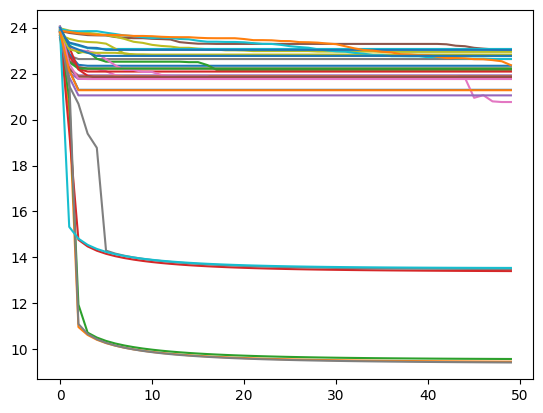

In [353]:
plt.plot(np.log(pd.DataFrame(all_losses_to_plot)) );

GENERACION:  0
BEST LOSS: 12839.546875
POBLACION: 62
[<matplotlib.lines.Line2D object at 0x7fd7f9c8ce20>, <matplotlib.lines.Line2D object at 0x7fd7f9c8e770>, <matplotlib.lines.Line2D object at 0x7fd7f9c8ef80>, <matplotlib.lines.Line2D object at 0x7fd7f9c8c1f0>, <matplotlib.lines.Line2D object at 0x7fd7f9c8fb50>, <matplotlib.lines.Line2D object at 0x7fd7f9c8c3d0>, <matplotlib.lines.Line2D object at 0x7fd7f9c8cd90>, <matplotlib.lines.Line2D object at 0x7fd7f9c8dbd0>, <matplotlib.lines.Line2D object at 0x7fd7f9c8ffd0>, <matplotlib.lines.Line2D object at 0x7fd7f9c8f280>, <matplotlib.lines.Line2D object at 0x7fd7f9c8de40>, <matplotlib.lines.Line2D object at 0x7fd7f9c8ec20>, <matplotlib.lines.Line2D object at 0x7fd7f9c8f670>, <matplotlib.lines.Line2D object at 0x7fd7f9c8f7c0>, <matplotlib.lines.Line2D object at 0x7fd7f9c8d540>, <matplotlib.lines.Line2D object at 0x7fd7f9c8eb90>, <matplotlib.lines.Line2D object at 0x7fd7f9c8c6d0>, <matplotlib.lines.Line2D object at 0x7fd7f9c8cd00>, <matplotli

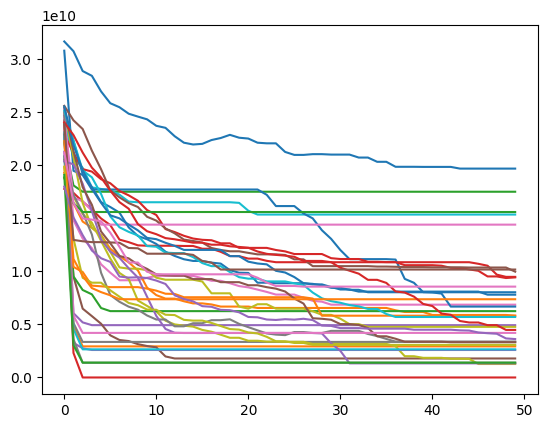

GENERACION:  1
BEST LOSS: 365844.6875
POBLACION: 67
[<matplotlib.lines.Line2D object at 0x7fd7d87dc760>, <matplotlib.lines.Line2D object at 0x7fd7d87dcca0>, <matplotlib.lines.Line2D object at 0x7fd7d87dd330>, <matplotlib.lines.Line2D object at 0x7fd7d87dcd90>, <matplotlib.lines.Line2D object at 0x7fd7d87dd720>, <matplotlib.lines.Line2D object at 0x7fd7d87de680>, <matplotlib.lines.Line2D object at 0x7fd7d87dc160>, <matplotlib.lines.Line2D object at 0x7fd7d87de7a0>, <matplotlib.lines.Line2D object at 0x7fd7b42cc940>, <matplotlib.lines.Line2D object at 0x7fd7b42ce410>, <matplotlib.lines.Line2D object at 0x7fd7d87deef0>, <matplotlib.lines.Line2D object at 0x7fd7b42ce4a0>, <matplotlib.lines.Line2D object at 0x7fd7b42cffd0>, <matplotlib.lines.Line2D object at 0x7fd7b42cca90>, <matplotlib.lines.Line2D object at 0x7fd7b42ce3e0>, <matplotlib.lines.Line2D object at 0x7fd7b42cf8b0>, <matplotlib.lines.Line2D object at 0x7fd7b42cd630>, <matplotlib.lines.Line2D object at 0x7fd7b42cc2b0>, <matplotlib

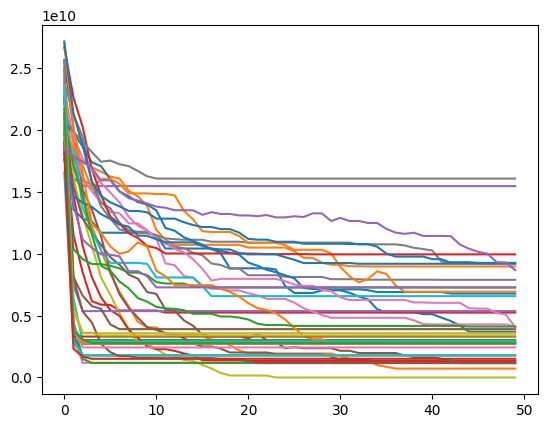

GENERACION:  2
BEST LOSS: 309962.0625
POBLACION: 67
[<matplotlib.lines.Line2D object at 0x7fd83534d1e0>, <matplotlib.lines.Line2D object at 0x7fd83534eaa0>, <matplotlib.lines.Line2D object at 0x7fd83534eda0>, <matplotlib.lines.Line2D object at 0x7fd83534cf10>, <matplotlib.lines.Line2D object at 0x7fd83534d060>, <matplotlib.lines.Line2D object at 0x7fd83534d660>, <matplotlib.lines.Line2D object at 0x7fd83534d450>, <matplotlib.lines.Line2D object at 0x7fd83534fb50>, <matplotlib.lines.Line2D object at 0x7fd83534e8f0>, <matplotlib.lines.Line2D object at 0x7fd830cddae0>, <matplotlib.lines.Line2D object at 0x7fd830cdc370>, <matplotlib.lines.Line2D object at 0x7fd830cdd660>, <matplotlib.lines.Line2D object at 0x7fd83534fac0>, <matplotlib.lines.Line2D object at 0x7fd83534f0d0>, <matplotlib.lines.Line2D object at 0x7fd83534e890>, <matplotlib.lines.Line2D object at 0x7fd83534e3e0>, <matplotlib.lines.Line2D object at 0x7fd83534efe0>, <matplotlib.lines.Line2D object at 0x7fd83534ee90>, <matplotlib

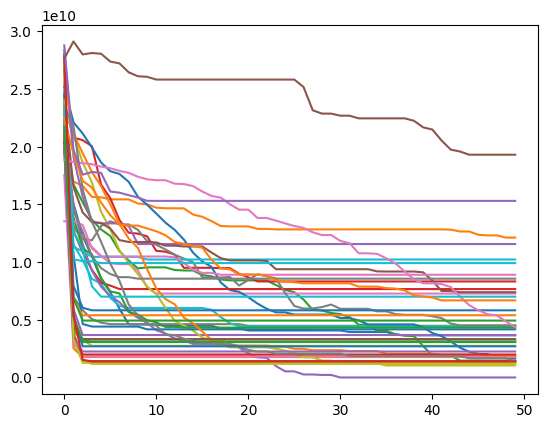

GENERACION:  3
BEST LOSS: 13564.1064453125
POBLACION: 66
[<matplotlib.lines.Line2D object at 0x7fd7e03f0a00>, <matplotlib.lines.Line2D object at 0x7fd7e03f1720>, <matplotlib.lines.Line2D object at 0x7fd7e03f3fd0>, <matplotlib.lines.Line2D object at 0x7fd7e03f03a0>, <matplotlib.lines.Line2D object at 0x7fd7e03f3e50>, <matplotlib.lines.Line2D object at 0x7fd7e03f29b0>, <matplotlib.lines.Line2D object at 0x7fd7e03f0ac0>, <matplotlib.lines.Line2D object at 0x7fd7e03f3040>, <matplotlib.lines.Line2D object at 0x7fd7e03f1a50>, <matplotlib.lines.Line2D object at 0x7fd7e03f1570>, <matplotlib.lines.Line2D object at 0x7fd7e03f1030>, <matplotlib.lines.Line2D object at 0x7fd7e03f3eb0>, <matplotlib.lines.Line2D object at 0x7fd7e03f1db0>, <matplotlib.lines.Line2D object at 0x7fd7e03f3df0>, <matplotlib.lines.Line2D object at 0x7fd7e03f1cf0>, <matplotlib.lines.Line2D object at 0x7fd7e03f1f90>, <matplotlib.lines.Line2D object at 0x7fd7e03f3640>, <matplotlib.lines.Line2D object at 0x7fd7e03f1a80>, <matpl

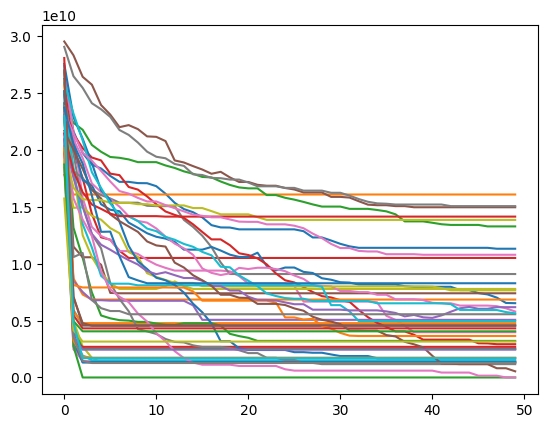

GENERACION:  4
BEST LOSS: 12589.4287109375
POBLACION: 67
[<matplotlib.lines.Line2D object at 0x7fd74b5cfc40>, <matplotlib.lines.Line2D object at 0x7fd74b5cebf0>, <matplotlib.lines.Line2D object at 0x7fd74b5cec80>, <matplotlib.lines.Line2D object at 0x7fd74b5cee00>, <matplotlib.lines.Line2D object at 0x7fd74b5cde40>, <matplotlib.lines.Line2D object at 0x7fd74b5cfa00>, <matplotlib.lines.Line2D object at 0x7fd74b5cee30>, <matplotlib.lines.Line2D object at 0x7fd74b5ce110>, <matplotlib.lines.Line2D object at 0x7fd74b5cf430>, <matplotlib.lines.Line2D object at 0x7fd74b5cfe50>, <matplotlib.lines.Line2D object at 0x7fd74b5cfee0>, <matplotlib.lines.Line2D object at 0x7fd74b5ced70>, <matplotlib.lines.Line2D object at 0x7fd74b5cf610>, <matplotlib.lines.Line2D object at 0x7fd74b5cfb20>, <matplotlib.lines.Line2D object at 0x7fd74b5cfa90>, <matplotlib.lines.Line2D object at 0x7fd74b5cfe80>, <matplotlib.lines.Line2D object at 0x7fd74b5cd690>, <matplotlib.lines.Line2D object at 0x7fd74b5ce080>, <matpl

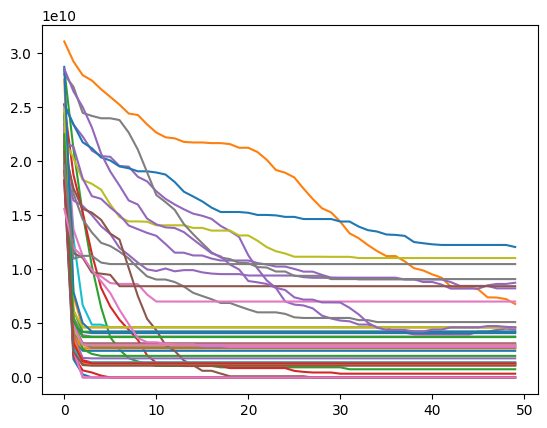

GENERACION:  5
BEST LOSS: 13530.6904296875
POBLACION: 66
[<matplotlib.lines.Line2D object at 0x7fd776106d10>, <matplotlib.lines.Line2D object at 0x7fd7761063e0>, <matplotlib.lines.Line2D object at 0x7fd776105360>, <matplotlib.lines.Line2D object at 0x7fd776106e00>, <matplotlib.lines.Line2D object at 0x7fd776107730>, <matplotlib.lines.Line2D object at 0x7fd776104b50>, <matplotlib.lines.Line2D object at 0x7fd776106b00>, <matplotlib.lines.Line2D object at 0x7fd776107640>, <matplotlib.lines.Line2D object at 0x7fd776104790>, <matplotlib.lines.Line2D object at 0x7fd776107670>, <matplotlib.lines.Line2D object at 0x7fd8282565f0>, <matplotlib.lines.Line2D object at 0x7fd776105510>, <matplotlib.lines.Line2D object at 0x7fd776191c30>, <matplotlib.lines.Line2D object at 0x7fd77f7c7490>, <matplotlib.lines.Line2D object at 0x7fd77f7c5210>, <matplotlib.lines.Line2D object at 0x7fd77f7c7910>, <matplotlib.lines.Line2D object at 0x7fd77f7c74c0>, <matplotlib.lines.Line2D object at 0x7fd77f7c4f10>, <matpl

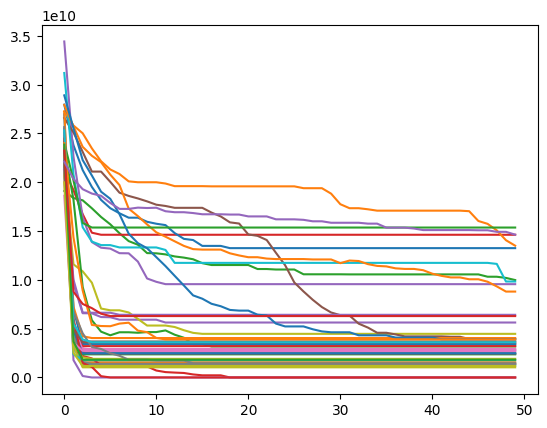

GENERACION:  6
BEST LOSS: 13206.533203125
POBLACION: 69
[<matplotlib.lines.Line2D object at 0x7fd80553f8e0>, <matplotlib.lines.Line2D object at 0x7fd80553c970>, <matplotlib.lines.Line2D object at 0x7fd7b8166cb0>, <matplotlib.lines.Line2D object at 0x7fd7b8166110>, <matplotlib.lines.Line2D object at 0x7fd7b8164160>, <matplotlib.lines.Line2D object at 0x7fd80553c9a0>, <matplotlib.lines.Line2D object at 0x7fd80553fac0>, <matplotlib.lines.Line2D object at 0x7fd80553c370>, <matplotlib.lines.Line2D object at 0x7fd80553ca00>, <matplotlib.lines.Line2D object at 0x7fd80553c790>, <matplotlib.lines.Line2D object at 0x7fd80553fc40>, <matplotlib.lines.Line2D object at 0x7fd80553d360>, <matplotlib.lines.Line2D object at 0x7fd80553ea70>, <matplotlib.lines.Line2D object at 0x7fd80553c430>, <matplotlib.lines.Line2D object at 0x7fd80553ca30>, <matplotlib.lines.Line2D object at 0x7fd80553de70>, <matplotlib.lines.Line2D object at 0x7fd80553d960>, <matplotlib.lines.Line2D object at 0x7fd80553e290>, <matplo

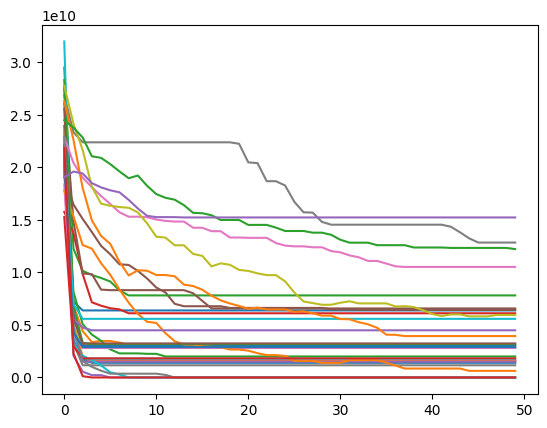

GENERACION:  7
BEST LOSS: 12367.6005859375
POBLACION: 70
[<matplotlib.lines.Line2D object at 0x7fd8010a8760>, <matplotlib.lines.Line2D object at 0x7fd8010aabf0>, <matplotlib.lines.Line2D object at 0x7fd8010a93c0>, <matplotlib.lines.Line2D object at 0x7fd8010abf10>, <matplotlib.lines.Line2D object at 0x7fd8010ab940>, <matplotlib.lines.Line2D object at 0x7fd8010ab340>, <matplotlib.lines.Line2D object at 0x7fd8010abbe0>, <matplotlib.lines.Line2D object at 0x7fd7f05cfa90>, <matplotlib.lines.Line2D object at 0x7fd7f05cc190>, <matplotlib.lines.Line2D object at 0x7fd7f05cdde0>, <matplotlib.lines.Line2D object at 0x7fd7f05ce920>, <matplotlib.lines.Line2D object at 0x7fd8010aa170>, <matplotlib.lines.Line2D object at 0x7fd835439b70>, <matplotlib.lines.Line2D object at 0x7fd83543bc10>, <matplotlib.lines.Line2D object at 0x7fd83543ad10>, <matplotlib.lines.Line2D object at 0x7fd835438040>, <matplotlib.lines.Line2D object at 0x7fd83543acb0>, <matplotlib.lines.Line2D object at 0x7fd83543b0d0>, <matpl

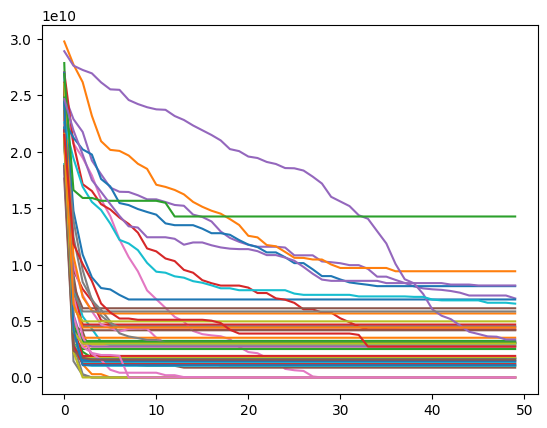

GENERACION:  8
BEST LOSS: 13188.625
POBLACION: 69
[<matplotlib.lines.Line2D object at 0x7fd7903e77c0>, <matplotlib.lines.Line2D object at 0x7fd7903e5060>, <matplotlib.lines.Line2D object at 0x7fd7903e6b90>, <matplotlib.lines.Line2D object at 0x7fd7903e7640>, <matplotlib.lines.Line2D object at 0x7fd7903e73a0>, <matplotlib.lines.Line2D object at 0x7fd7903e71f0>, <matplotlib.lines.Line2D object at 0x7fd7903e5ed0>, <matplotlib.lines.Line2D object at 0x7fd7903e5330>, <matplotlib.lines.Line2D object at 0x7fd7903e6590>, <matplotlib.lines.Line2D object at 0x7fd7903e4df0>, <matplotlib.lines.Line2D object at 0x7fd7903e71c0>, <matplotlib.lines.Line2D object at 0x7fd7903e6da0>, <matplotlib.lines.Line2D object at 0x7fd7903e5c00>, <matplotlib.lines.Line2D object at 0x7fd7903e4ac0>, <matplotlib.lines.Line2D object at 0x7fd7903e6020>, <matplotlib.lines.Line2D object at 0x7fd7903e4d60>, <matplotlib.lines.Line2D object at 0x7fd7903e6e30>, <matplotlib.lines.Line2D object at 0x7fd7903e6ad0>, <matplotlib.l

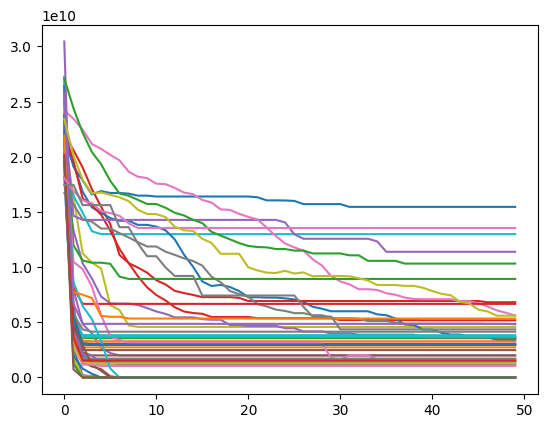

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7fd8c7bf15a0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [340]:
from IPython.display import display, clear_output

for i in range(numero_generaciones):
  # guardamos el ultimo loss para el fitness
  his = []
  nuevos_individuos = []
  # guardamos el entrenamiento para poder observarlo
  all_losses_to_plot = {}
  # ENTRENAMIENTO
  for m in poblacion:

    h = m.fit(X_train, Y_train, epochs=epochs, batch_size = X_train.shape[0], callbacks=[early_stopping, loss_under_avg_cb], verbose=0)

    if len(h.history["loss"]) == epochs:
      all_losses_to_plot[len(all_losses_to_plot)] = h.history["loss"]

    his.append(h.history["loss"][-1])

  
    #his.append( (m.fit(X_train, Y_train, epochs=epochs, batch_size = X_train.shape[0], callbacks=[early_stopping, loss_under_avg_cb], verbose=0)).history["loss"][-1] )
  ################################################################################

  # EVALUACION FITNESS

  # añadimos los mejores a la siguiente generacion
  indices_individuos_seleccionados = seleccion_individuos(his, numero_individuos_selecionados)
  nuevos_individuos = individuos[indices_individuos_seleccionados]

  parejas = []
  
  for _ in range(num_parejas_seleccion):
    nueva_pareja = tournament_selection(his, np.array(his), 2, tournament_size)
    parejas.append(nueva_pareja)
  ################################################################################
  
  # CRUCE
  
  for pareja in parejas:
  
    parent1 = individuos[int(pareja[0])]
    parent2 = individuos[int(pareja[1])]
    child1, child2 = uniform_crossover(parent1, parent2)
    
    # MUTACION
    random_number = np.random.rand()
    if random_number < prob_mutacion:
      layers_random = np.random.randint(-1, len(layers), (1, num_genes))
      child1[::len_gen] = layers_random[0]
    random_number = np.random.rand()
    if random_number < prob_mutacion:
      activations_random = np.random.randint(0, len(activations), (1, num_genes))
      child1[1::len_gen] = activations_random[0]
    random_number = np.random.rand()
    if random_number < prob_mutacion:
      units_random = np.random.randint(rango_minimo_units, rango_maximo_units, (1, num_genes))
      child1[2::len_gen] = units_random[0]
    random_number = np.random.rand()
    if random_number < prob_mutacion:
      kernels_size_random = np.random.randint(rango_minimo_kernel_size, rango_maximo_kernel_size, (1, num_genes))
      child1[3::len_gen] = kernels_size_random[0]
    ################################################################################

    # añadimos los nuevos individuos para la neuva generacion
    nuevos_individuos = np.vstack((nuevos_individuos, child1))
    nuevos_individuos = np.vstack((nuevos_individuos, child2))
  ################################################################################

  # INMIGRACION
  num_individuos = nuevos_inmigrantes
  new_rand_ind = creacion_individuos_genes()

  nuevos_individuos = np.vstack((nuevos_individuos, new_rand_ind))
  ################################################################################

  # REEMPLAZO
  individuos = nuevos_individuos

  poblacion = creacion_individuos_to_models(individuos)
  #print(len(poblacion))
  filter_indices = kill_big_models(poblacion, params_limit = 800000)

  poblacion  = np.array(poblacion)[filter_indices]
  #print(len(poblacion))
  individuos = individuos[filter_indices]
  ################################################################################

  # STADISTICAS GENERACION
  print("GENERACION: " + " " + str(i))

  best_loss_generacion = np.array(his)[indices_individuos_seleccionados[:1]][0]
  print("BEST LOSS: " + str(best_loss_generacion))
  best_losses.append(best_loss_generacion)

  all_his.append(his)

  print("POBLACION: " + str(len(poblacion)))

  plt.figure()
  plt.plot(np.log(pd.DataFrame(all_losses_to_plot)) );
  display(plt.gcf())
  #clear_output(wait = True)
  plt.close()
  ################################################################################




  

In [ ]:
plt.plot(best_losses)